In [1]:
%load_ext autoreload
%autoreload 2

# Load the configs and set up the plotting 

In [2]:
import datetime
import os
import pickle
import sys
import time

import matplotlib.pyplot as plt
import numpy as np
from omegaconf import OmegaConf
from torch.distributions import MultivariateNormal

from labproject.data import DATASETS, DISTRIBUTIONS, get_dataset
from labproject.experiments import *
from labproject.plotting import cm2inch, generate_palette
from labproject.utils import get_cfg, get_cfg_from_file, get_log_path, set_seed

# inline plotting
%matplotlib inline



print("Running experiments...")
# load the config file
cfg = get_cfg_from_file("conf_mmd_bandwidth_experiment")
cfg.running_user = 'MMD_scale_bandwidth'
seed = cfg.seed

set_seed(seed)
print(f"Seed: {seed}")
print(f"Experiments: {cfg.experiments}") 
print(f"Data: {cfg.data}")

# assert cfg.data is list
assert len(cfg.data) == len(cfg.n) == len(cfg.d), "Data, n and d must be lists of the same length"
    
# setup colors and labels for plotting

color_dict = {"wasserstein": "#cc241d",
              "mmd": "#eebd35",
              "c2st": "#458588",
              "fid": "#8ec07c", 
              "kl": "#8ec07c"}


col_map = {'ScaleSampleSizeKL':'kl', 'ScaleSampleSizeSW':'wasserstein',
           'ScaleSampleSizeMMD':'mmd', 'ScaleSampleSizeC2ST':'c2st',
           'ScaleSampleSizeFID':'fid', 'ScaleDimKL':'kl', 'ScaleDimSW':'wasserstein',
           'ScaleDimMMD':'mmd', 'ScaleDimC2ST':'c2st', 'ScaleGammaMMD':'mmd',
           'ScaleDimFID':'fid',}

mapping = {'ScaleSampleSizeKL':'KL', 'ScaleSampleSizeSW':'SW',
           'ScaleSampleSizeMMD':'MMD', 'ScaleSampleSizeC2ST':'C2ST',
           'ScaleSampleSizeFID':'FD', 'ScaleDimKL':'KL', 'ScaleDimSW':'SW',
           'ScaleDimMMD':'MMD', 'ScaleDimC2ST':'C2ST',
           'ScaleDimFID':'FD', 'ScaleGammaMMD':'MMD'}

# dark and light colors for inter vs. intra comparisons 
col_dark = {}
col_light = {}
for e, exp_name in enumerate(cfg.experiments):
    col_dark[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='dark')[2]
    col_light[exp_name] = generate_palette(color_dict[col_map[exp_name]], saturation='light')[-1]

color_list = [col_light, col_dark] # make this a list to account for true and shifted

label_true = {}
label_shift = {}
for e, data_name in enumerate(cfg.data):
    label_true[data_name] = "true"
    label_shift[data_name] = "generated"
    
label_list = [label_true, label_shift]
label_list[1]['toy_2d'] = 'approx.'
label_list[1]['random'] = 'shifted'


Running experiments...
Seed: 0
Experiments: ['ScaleGammaMMD', 'ScaleGammaMMD', 'ScaleGammaMMD']
Data: ['toy_2d', 'random', 'random']


# Loop over the three datasets for respective MMD bandwidth ranges

toy_2d 2000 2


/tmp/ipykernel_1238676/2600125742.py:30: UserWarning: The use of `x.T` on tensors of dimension other than 2 to reverse their shape is deprecated and it will throw an error in a future release. Consider `x.mT` to transpose batches of matrices or `x.permute(*torch.arange(x.ndim - 1, -1, -1))` to reverse the dimensions of a tensor. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3637.)
  torch.mean(dataset_gt, axis=0).T, torch.cov(dataset_gt.T)


Experiment ScaleGammaMMD finished in 0.2555234432220459
Numerical results saved to results/MMD_scale_bandwidth/MMD_bandwidth_experiment_MMD_toy_2d_ds_0_0_.pkl
Experiment ScaleGammaMMD finished in 0.2632288932800293
Numerical results saved to results/MMD_scale_bandwidth/MMD_bandwidth_experiment_MMD_toy_2d_ds_0_1_.pkl
random 2000 10
Experiment ScaleGammaMMD finished in 0.20831036567687988
Numerical results saved to results/MMD_scale_bandwidth/MMD_bandwidth_experiment_MMD_random_ds_1_0_.pkl
Experiment ScaleGammaMMD finished in 0.2370905876159668
Numerical results saved to results/MMD_scale_bandwidth/MMD_bandwidth_experiment_MMD_random_ds_1_1_.pkl
random 2000 100
Experiment ScaleGammaMMD finished in 0.3269484043121338
Numerical results saved to results/MMD_scale_bandwidth/MMD_bandwidth_experiment_MMD_random_ds_2_0_.pkl
Experiment ScaleGammaMMD finished in 0.3149991035461426
Numerical results saved to results/MMD_scale_bandwidth/MMD_bandwidth_experiment_MMD_random_ds_2_1_.pkl
Finished runni

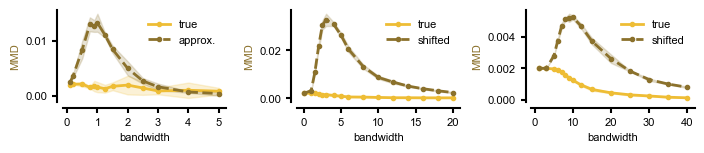

In [3]:
fig, axes = plt.subplots(1, 3, figsize=cm2inch((18, 4)), sharex="col")

for ax in axes.flatten():
    # move spines outward
    ax.spines["bottom"].set_position(("outward", 4))
    ax.spines["left"].set_position(("outward", 4))
    ax.locator_params(axis="y", nbins=3)
    ax.locator_params(axis="x", nbins=8)

# Loop over all three datasets
for dd, ds in enumerate(cfg.data):

    # specify the bandwidth parameters to vary for each dataset
    # custom_values = np.linspace(cfg.val_min[dd], cfg.val_max[dd], cfg.val_step[dd]) # switch for linspacing
    custom_values = np.array(cfg.value_sizes[dd])

    dataset_fn = get_dataset(cfg.data[dd])
    # sample double the number of samples to ensure variability at the highest samples set size
    n_samples = cfg.n[dd] * 2

    # generate the ground truth and the two approximations inter and intra
    dataset_gt = dataset_fn(n_samples, cfg.d[dd])
    dataset_intra = dataset_fn(n_samples, cfg.d[dd])

    print(cfg.data[dd], n_samples, cfg.d[dd])

    # generate the inter dataset
    if cfg.data[dd] == "toy_2d":
        dataset_inter = MultivariateNormal(
            torch.mean(dataset_gt, axis=0).T, torch.cov(dataset_gt.T)
        ).sample((n_samples,))
    elif cfg.data[dd] == "random" and cfg.augmentation[dd] == "mean_shift":
        # shift the mean by 1 for all dimensions
        dataset_inter = dataset_fn(n_samples, cfg.d[dd]) + 1
    elif cfg.data[dd] == "random" and cfg.augmentation[dd] == "one_dim_shift":
        # just shift the first dimension by 1
        dataset_inter = dataset_fn(n_samples, cfg.d[dd])
        dataset_inter[:, 0] += 1  # just shift the mean of first dim by 1

    experiment = globals()[exp_name](value_sizes=custom_values)
    ax = axes[dd]

    for dc, data_comp in enumerate([dataset_intra, dataset_inter]):

        assert (
            dataset_gt.shape == data_comp.shape
        ), f"Dataset shapes do not match: {dataset_gt.shape} vs. {data_comp.shape}"

        time_start = time.time()
        output = experiment.run_experiment(dataset1=dataset_gt, dataset2=data_comp, n=cfg.n[dd])
        time_end = time.time()
        print(f"Experiment {exp_name} finished in {time_end - time_start}")

        # log the results to the experiment folder
        log_path = get_log_path(
            cfg, tag=f"_{mapping[exp_name]}_{cfg.data[dd]}_ds_{dd}_{dc}", timestamp=False
        )
        os.makedirs(os.path.dirname(log_path), exist_ok=True)
        experiment.log_results(output, log_path)
        print(f"Numerical results saved to {log_path}")

        # plot experiment results
        experiment.plot_experiment(
            *output,
            cfg.data[dd],
            ax=ax,
            color=color_list[dc][exp_name],
            label=label_list[dc][cfg.data[dd]],
            linestyle="-" if dc == 0 else "--",
            lw=2,
            marker="o",
        )
    ax.legend()

axes[-1].set_xlabel("bandwidth")
axes[0].set_xlabel("bandwidth")
axes[1].set_xlabel("bandwidth")

fig.tight_layout()
# if folder results/plots does not exist, create it
os.makedirs("./results/plots", exist_ok=True)
fig.savefig(f"./results/plots/MMD_scale_bandwidth_{cfg.n[0]}.png", dpi=300)
fig.savefig(f"./results/plots/MMD_scale_bandwidth_{cfg.n[0]}.pdf", dpi=300)

print("Finished running experiments.")